In [418]:
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.linear_model import OrthogonalMatchingPursuit
# import sparse 
import scipy.sparse as sparse
# import stats
import scipy.stats as stats
import math
import time
from scipy.linalg import dft
from scipy.interpolate import make_interp_spline
import statistics

In [3]:
def coeffienct():
    #ytheta=np.exp((math.pi)*np.random.uniform(-1,1)*1j)/np.sqrt(P)
    ytheta=np.random.normal(0,1/np.sqrt(4*P))+1j*np.random.normal(0,1/np.sqrt(4*P))
    return ytheta

def aoa(x):
    a=np.zeros((N,1),dtype=complex)
    for i in range(N):
        a[i]=np.exp(1j*math.pi*np.sin(x)*i)/np.sqrt(N)
    return a

In [408]:
def omp(y, A, train,L):
    """y: observation;
    A: dictionary, each column is an atom. Note: atoms much be normalized;
    L: number of non-zero entries in output(threshold)
    output is a vector that stores the coefficient of each atom"""
    
    m=np.shape(A)[1]
    t=np.zeros((m,1),dtype=complex)
    r=y    #residual
    selected=[]
    if train==True:
        for iter in range (L):
            dot_p=np.dot(np.matrix(A,dtype=complex,copy=True).H,r)
            i=np.argmax(abs(dot_p))
            selected.append(i)
            temp=A[:,selected]
            a=np.dot(np.linalg.pinv(temp),y) 
            r=y-np.dot(temp,a)
            

            for j in range(iter+1):
                t[selected[j]]=a[j]
    
    else:
        iter=0
        while np.sum(np.abs(r)**2)/len(y) > L and iter <25:
            dot_p=np.dot(np.matrix(A,dtype=complex,copy=True).H,r)
            i=np.argmax(abs(dot_p))
            selected.append(i)
            temp=A[:,selected]
            a=np.dot(np.linalg.pinv(temp),y) 
            r=y-np.dot(temp,a)
            for j in range(iter+1):
                t[selected[j]]=a[j]
            iter+=1
    t=t.reshape(1,-1).reshape(-1)
    return t

def stomp(y, A,L,th):
    """y: observation;
    A: dictionary, each column is an atom. Note: atoms much be normalized;
    L: number of non-zero entries in output(threshold)
    output is a vector that stores the coefficient of each atom"""
    
    m=np.shape(A)[1]
    t=np.zeros((m,1),dtype=complex)
    r=y    #residual
    selected=[]
    
    for iter in range (L):
        dot_p=np.dot(np.matrix(A,dtype=complex,copy=True).H,r)
        dot_p=np.asarray(dot_p).reshape(-1)
           
        for k in range(m):
            if abs(dot_p)[k]>th:
                selected.append(k)
                    
        temp=A[:,selected]
        a=np.dot(np.linalg.pinv(temp),y) 
        r=y-np.dot(temp,a)
      
            

        for j in range(len(selected)):
            t[selected[j]]=a[j]

    t=t.reshape(1,-1).reshape(-1)
    return t

def gd(y, A, i, gama,s):
     
    
    N=A.shape[1]
    n=A.shape[0]
    x = np.zeros(N, dtype=complex)
    for j in range(i):
        x=x+(1/gama)*np.asarray(np.dot(np.matrix(A,dtype=complex,copy=True).H,(y-np.dot(A,x).reshape(1,-1).reshape(-1)))).reshape(-1)
        selected=[]
        x1=x.copy()
        for k in range(s):
            
            index=np.argmax(abs(x1))
            selected.append(index)
            x1[index]=0
            
        for w in range(N):
            if w not in selected:
                x[w]=0
    
    
    return x   

def codebookupdate(Y, A, X):
    """Y: a matrix of observations
    A: present dictioanary needed to be updated
    X: a matrix of sparse solutions"""

    N=np.shape(X)[1]
    K=np.shape(X)[0]
    
    for k in range(K):

        #print(X[k])
        W=np.nonzero(X[k])          #choose the non zero index of row Xk
        if len(W[0])!=0:            #compute the overall representation error matrix
            E=Y.copy()
            for j in range(K):
                if j!=k:
                    E-= np.dot(A[:,j].reshape(-1,1),X[j].reshape(-1,1).T)
            #print(np.sum(np.abs(E-np.dot(A[:,k].reshape(-1,1),X[k].reshape(-1,1).T))),"1")
            E=E[:,W[0]]            #choose the only correspoding colums in E
            #print(np.sum(np.abs(Y-np.dot(A,X))),"2")
            U,sig,VT=svd(E)         #svd
            A[:,k]=U[:,0]
            Xr=VT*sig[0]
            Xr=Xr[0]
            X[k][W[0]]=Xr
            
    for i in range(np.shape(A)[1]):
        A[:,i]=A[:,i]/np.linalg.norm(A[:,i])
    return A

def codebookupdatemod(Y,A,X):
    
    A=np.dot(Y,np.linalg.pinv(X))
    for i in range(np.shape(A)[1]):
        A[:,i]=A[:,i]/np.linalg.norm(A[:,i])
    
    return A

def recoveryst(Y, A,L,th):
    N=Y.shape[1]
    k=A.shape[1]
    X=np.zeros((k,N),dtype=complex)
    for i in range(N):
        X[:,i]= stomp(Y[:,i], A,L,th)
    return X

def recoverygd(Y, A, I, gama,s):
    N=Y.shape[1]
    k=A.shape[1]
    X=np.zeros((k,N),dtype=complex)
    for i in range(N):
        X[:,i]= gd(Y[:,i], A,I, gama,s)
    return X


def sparsecoding(Y,A,train,L):
    N=Y.shape[1]
    k=A.shape[1]
    X=np.zeros((k,N),dtype=complex)
    for i in range(N):
        X[:,i]= omp(Y[:,i],A,train,L)
    return X
    

def ksvd(Y,Aini,J,L,train):
    A=Aini.copy()
    cost=[]
    for j in range(J):
        X=sparsecoding(Y,A,train,L)
        cost.append(np.sum(np.abs(Y-np.dot(A,X))))
        A=codebookupdate(Y,A,X)
        #cost.append(np.sum(np.abs(Y-np.dot(A,X))))
       
       # print(np.sum(np.abs(A)))
    x = range(J)    
    plt.plot(x, cost)
    plt.xlabel("iteration")
    plt.ylabel("cost function")
    plt.title('cost function with ksvd') 
    plt.show()  

    return A,X,cost

def mod(Y,Aini, J,L):
    A=Aini.copy()
    cost=[]
    for j in range(J):
        X=sparsecoding(Y,A,True,L)
        A=codebookupdatemod(Y,A,X)
        cost.append(np.sum(np.abs(Y-np.dot(A,X))))
    x=range(J)
    
    plt.plot(x,cost)
    plt.xlabel("iteration")
    plt.ylabel("cost function")
    plt.title("cost with iteration MOD")
    plt.show()

    return A,X,cost

In [5]:
N=32
P=20
D=dft(N,scale='sqrtn')

#over dft
c=2
D_2=np.ones((N,c*N),dtype=complex)

for i in range(N):
    for k in range(c*N):
        D_2[i][k]=np.exp(-2j*math.pi*i*k/(N)) 
D_2=D_2/np.sqrt(N)

In [6]:
loc1, scale1 = np.random.randn()*np.pi,np.pi/36
loc2, scale2 =np.random.randn()*np.pi,np.pi/36

H=np.ones((N,10000),dtype=complex)
for j in range(10000):
    #loc1, scale1 = np.random.randn()*np.pi,np.pi/36
    #loc2, scale2 =np.random.randn()*np.pi,np.pi/36
    s1 = np.random.laplace(loc1, scale1, (P,1))
    s2= np.random.laplace(loc2, scale2, (P,1))   
    h=np.zeros((N,1),dtype=complex)
    for i in range(P):
        h+=coeffienct()*aoa(s1[i])
        h+=coeffienct()*aoa(s2[i]) 
    h=h/np.linalg.norm(h)
    H[:,j]=h.reshape(1,-1).reshape(-1) 

In [47]:
from scipy.stats import laplace

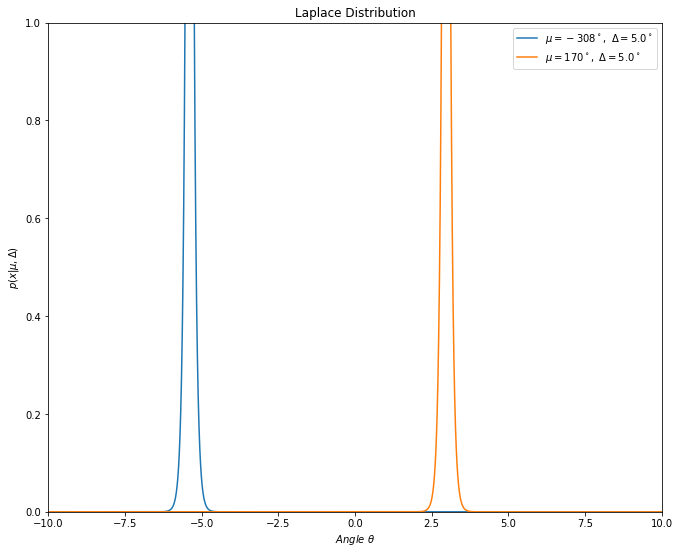

In [84]:

#------------------------------------------------------------
# Define the distribution parameters to be plotted
delta_values = [scale1,scale2]
linestyles = ['-', '--']
mus = [loc1,loc2]
x = np.linspace(-10, 10,10000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(11, 9))

for delta, mu in zip(delta_values,mus):
    dist = laplace(mu, delta)

    plt.plot(x, dist.pdf(x),  
             label=r'$\mu=%.1i^\circ,\ \Delta=%.1f^\circ$' % (math.degrees(mu), math.degrees(delta)))

plt.xlim(-10, 10)
plt.ylim(0, 1.0)

plt.xlabel('$Angle\ \\theta $')
plt.ylabel(r'$p(x|\mu,\Delta)$')
plt.title('Laplace Distribution')

plt.legend()
plt.savefig('laplace.pdf')
plt.show()


# compare two dictionary learning algorithms

##  c=1, iter=100, L=15

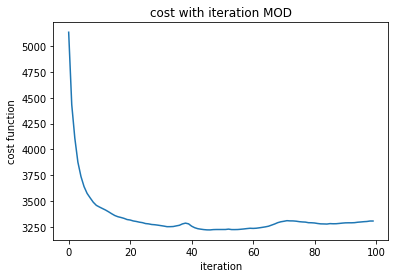

2349.3219859600067


In [7]:
start=time.time()
D1,_,cost1=mod(H,D,100,15)
end=time.time()
t1=end-start
print(t1)

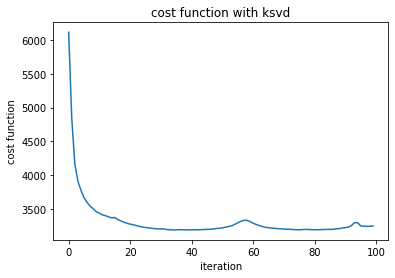

11861.05672287941


In [436]:
start=time.time()
D2,_,cost2=ksvd(H,D,100,15,True)
end=time.time()
t2=end-start
print(t2)

In [441]:
cost2

[6114.237916745183,
 4843.126072719486,
 4165.287593725552,
 3909.939938416539,
 3774.758950128094,
 3665.3033886499184,
 3594.5706625413222,
 3538.4312721939236,
 3502.2802160950496,
 3456.5399274104207,
 3436.626819405468,
 3410.1335594681605,
 3399.053529708504,
 3381.382308634614,
 3367.626276804892,
 3371.9435264753283,
 3340.671790934659,
 3320.694729802822,
 3302.9708531032175,
 3286.3587550899338,
 3273.7791928479573,
 3264.895950079542,
 3252.034160707421,
 3240.2549040658323,
 3231.1061534354058,
 3223.934352694856,
 3218.1745553352966,
 3212.1912816568865,
 3207.1372571483184,
 3204.3914738171457,
 3202.757732599675,
 3201.9864863780926,
 3194.4388814680797,
 3190.752462521966,
 3188.4605971493024,
 3189.145211336451,
 3192.176215792487,
 3190.2955098607513,
 3190.2959645232218,
 3189.9727853011796,
 3188.574792292841,
 3190.7655322274713,
 3190.3856383261286,
 3191.5956449696073,
 3194.301656308987,
 3196.4269586748346,
 3198.3217652006174,
 3201.609232675642,
 3209.5060063

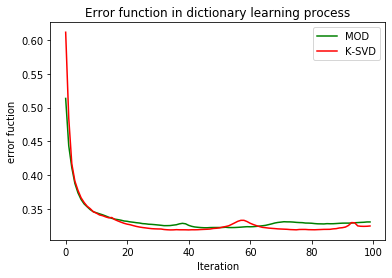

In [442]:
x=range(100)
cost1 = [number* 10000 for number in cost1]
cost2 = [number /10000 for number in cost2]
plt.plot(x, cost1, label = "MOD",color='g')
plt.plot(x, cost2, label = "K-SVD",color='r')
plt.xlabel('Iteration')
# Set the y axis label of the current axis.
plt.ylabel('error fuction')
# Set a title of the current axes.
plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('comparison1.pdf')
# Display a figure.
plt.show()

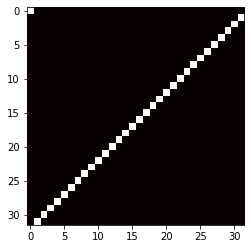

In [15]:
m=dft(32)
B=np.zeros_like(D)
for i in range(32):
    x=D[:,i]
    B[:,i]=m@x
B=np.abs(B)
plt.imshow(B, cmap='hot', interpolation='nearest')
plt.show()

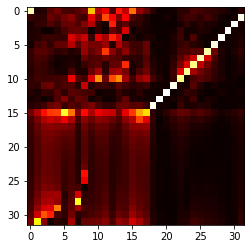

In [16]:
B1=np.zeros_like(D1)
for i in range(32):
    x=D1[:,i]
    B1[:,i]=m@x
B1=np.abs(B1)
plt.imshow(B1, cmap='hot', interpolation='nearest')
plt.show()

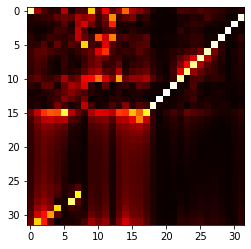

In [17]:
B2=np.zeros_like(D2)
for i in range(32):
    x=D2[:,i]
    B2[:,i]=m@x
B2=np.abs(B2)
plt.imshow(B2, cmap='hot', interpolation='nearest')
plt.show()

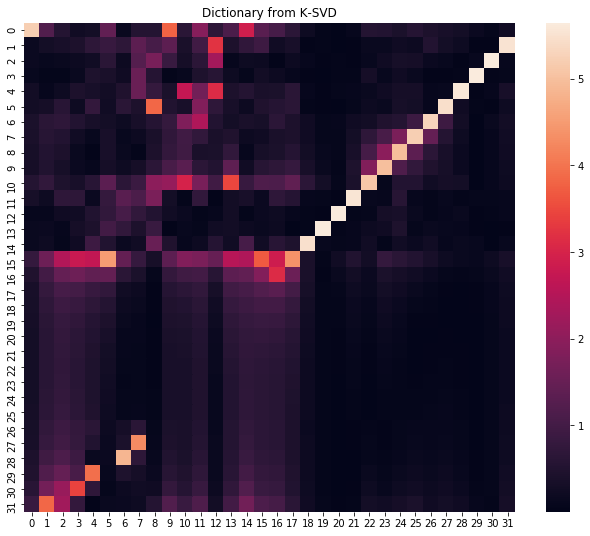

In [18]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B2)
plt.title('Dictionary from K-SVD')
plt.savefig('ksvd_d_1.pdf')
plt.show()

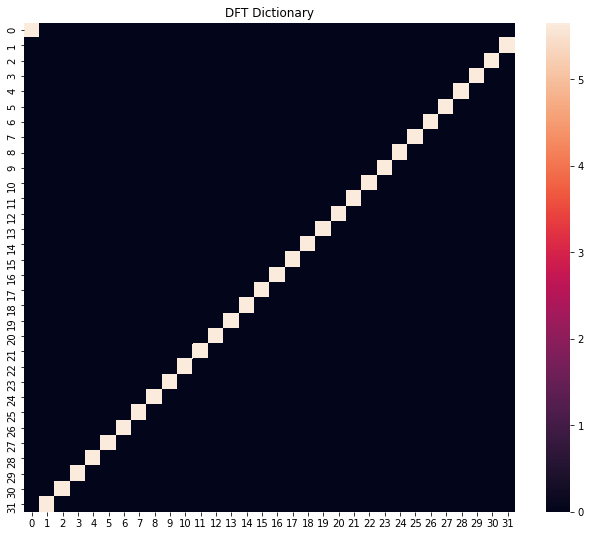

In [604]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B)
plt.title('DFT Dictionary')
plt.savefig('dft_d_1.pdf')
plt.show()

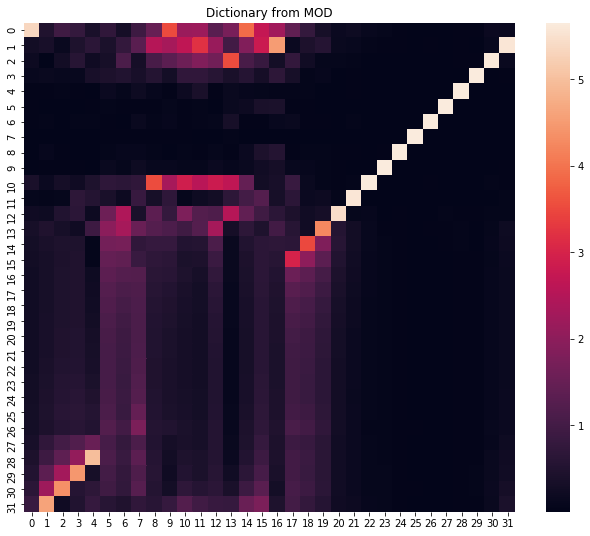

In [605]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B1)
plt.title('Dictionary from MOD')
plt.savefig('mod_d_1.pdf')
plt.show()

## c=2, iter=100, L=15

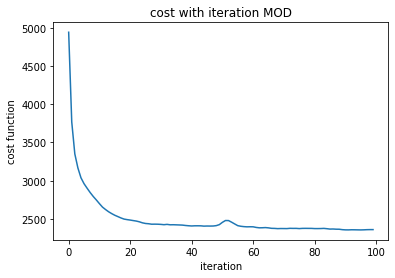

2406.115309715271


In [9]:
start=time.time()
D_21,_,cost21=mod(H,D_2,100,15)
end=time.time()
t1=end-start
print(t1)

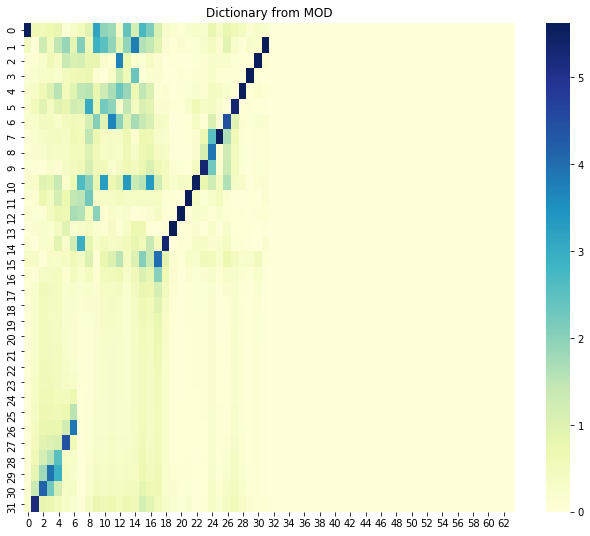

In [19]:
B_21=np.zeros_like(D_21)
for i in range(32):
    x=D_21[:,i]
    B_21[:,i]=m@x
B_21=np.abs(B_21)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B_21,cmap="YlGnBu")
plt.title('Dictionary from MOD')
plt.savefig('mod_d_2.pdf')
plt.show()

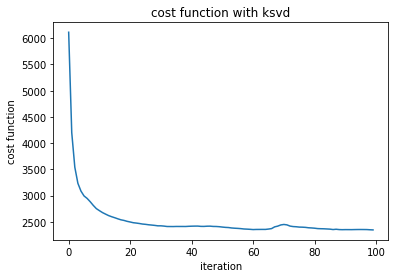

7402.807435035706


In [437]:
start=time.time()
D_22,_,cost22=ksvd(H,D_2,100,15,True)
end=time.time()
t2=end-start
print(t2)

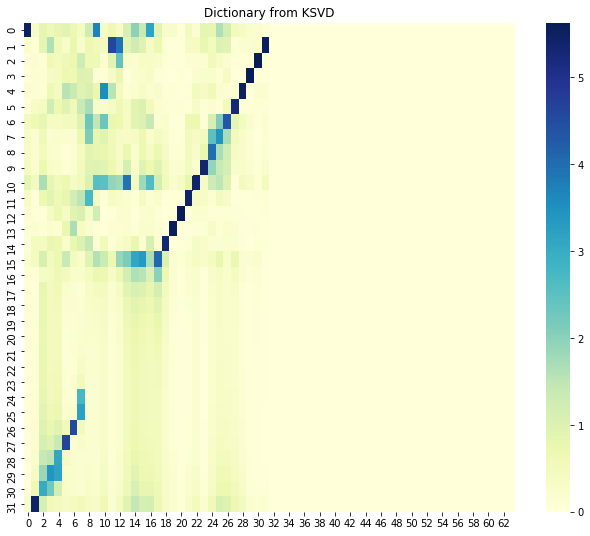

In [86]:
B_22=np.zeros_like(D_22)
for i in range(32):
    x=D_22[:,i]
    B_22[:,i]=m@x
B_22=np.abs(B_22)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B_22,cmap="YlGnBu")
plt.title('Dictionary from KSVD')
plt.savefig('ksvd_d_2.pdf')
plt.show()

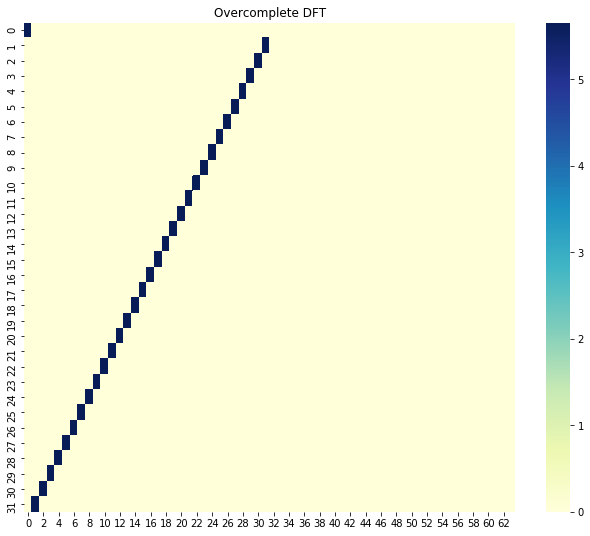

In [22]:
B_2=np.zeros_like(D_2)
for i in range(32):
    x=D_2[:,i]
    B_2[:,i]=m@x
B_2=np.abs(B_2)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B_2,cmap="YlGnBu")
plt.title('Overcomplete DFT')
plt.savefig('odft_d_2.pdf')
plt.show()

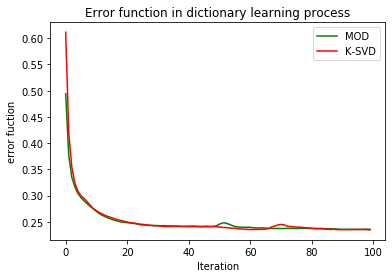

In [87]:
x=range(100)
#cost21 = [number / 10000 for number in cost21]
cost22 = [number / 10000 for number in cost22]
plt.plot(x, cost21, label = "MOD",color='g')
plt.plot(x, cost22, label = "K-SVD",color='r')
plt.xlabel('Iteration')
# Set the y axis label of the current axis.
plt.ylabel('error fuction')
# Set a title of the current axes.
plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('comparison2.pdf')
# Display a figure.
plt.show()

## c=1, iter=100, L= 25

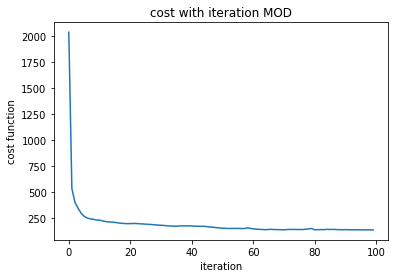

5304.474823951721


In [11]:
start=time.time()
D_31,_,cost31=mod(H,D_2,100,25)
end=time.time()
t1=end-start
print(t1)

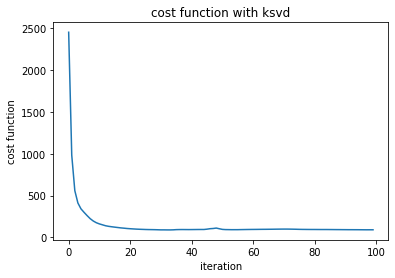

15723.497984170914


In [12]:
start=time.time()
D_32,_,cost32=ksvd(H,D_2,100,25,True)
end=time.time()
t2=end-start
print(t2)

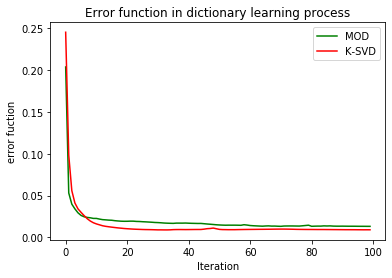

In [41]:
x=range(100)
cost31 = [number * 10000 for number in cost31]
cost32 = [number * 10000 for number in cost32]
plt.plot(x, cost31, label = "MOD",color='g')
plt.plot(x, cost32, label = "K-SVD",color='r')
plt.xlabel('Iteration')
# Set the y axis label of the current axis.
plt.ylabel('error fuction')
# Set a title of the current axes.
plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('comparison3.pdf')
# Display a figure.
plt.show()

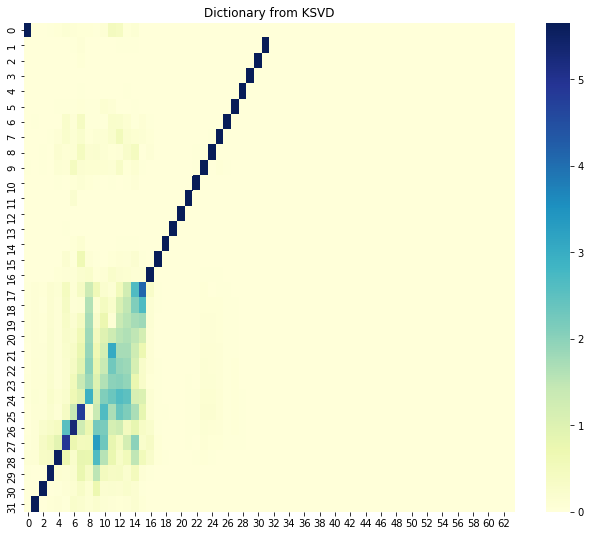

In [43]:
B_32=np.zeros_like(D_32)
for i in range(32):
    x=D_32[:,i]
    B_32[:,i]=m@x
B_32=np.abs(B_32)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B_32,cmap="YlGnBu")
plt.title('Dictionary from KSVD')
plt.savefig('ksvd_d_3.pdf')
plt.show()

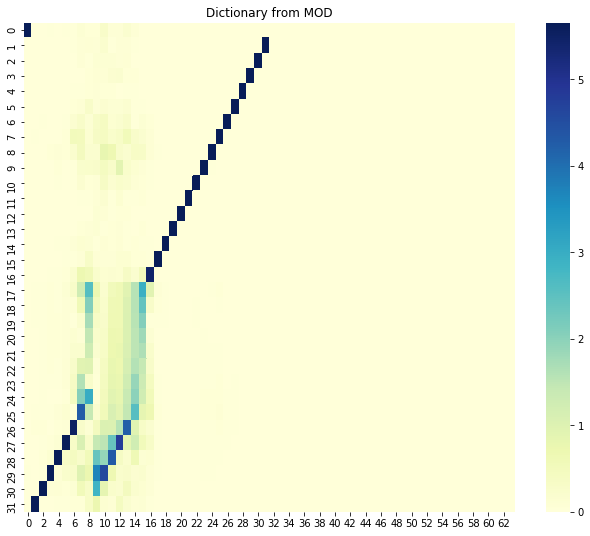

In [44]:
B_31=np.zeros_like(D_31)
for i in range(32):
    x=D_31[:,i]
    B_31[:,i]=m@x
B_31=np.abs(B_31)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(B_31,cmap="YlGnBu")
plt.title('Dictionary from MOD')
plt.savefig('mod_d_3.pdf')
plt.show()

# Phase 2 and 3

In [211]:
Hnew=np.zeros((N,1000),dtype=complex)
for j in range(1000):
    #loc1, scale1 = np.random.randint(0,np.pi),np.pi/36
    #loc2, scale2 =np.random.randint(0,np.pi),np.pi/36
    s1 = np.random.laplace(loc1, scale1, (P,1))
    s2= np.random.laplace(loc2, scale2, (P,1))   
    h=np.zeros((N,1),dtype=complex)
    for i in range(P):
        h+=coeffienct()*aoa(s1[i])
        h+=coeffienct()*aoa(s2[i])  
    h=h/np.linalg.norm(h)
    Hnew[:,j]=h.reshape(1,-1).reshape(-1)

In [261]:
def test(D1,D2,D3,D4,D5,D6,D7,D8,th,snr):
    
    snr=10**(0.1*snr)  #db to linear
    #Hreal=Hnew
    Hreal=Hnew+np.random.normal(0,1/np.sqrt(2*snr))+1j*np.random.normal(0,1/np.sqrt(2*snr))

    start=time.time()
    X1=sparsecoding(Hreal,D1,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X1),t)
    
    start=time.time()
    X2=sparsecoding(Hreal,D2,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X2),t)
    
    start=time.time()
    X3=sparsecoding(Hreal,D3,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X3),t)
    
    start=time.time()
    X4=sparsecoding(Hreal,D4,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X4),t)
    
    start=time.time()
    X5=sparsecoding(Hreal,D5,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X5),t)
    
    start=time.time()
    X6=sparsecoding(Hreal,D6,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X6),t)
    
    start=time.time()
    X7=sparsecoding(Hreal,D7,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X7),t)
    
    start=time.time()
    X8=sparsecoding(Hreal,D8,False,th)
    end=time.time()
    t=end-start
    print(np.count_nonzero(X8),t)
    
    
    
    
    E1=np.abs(Hnew-np.dot(D1,X1))
    E2=np.abs(Hnew-np.dot(D2,X2))
    E3=np.abs(Hnew-np.dot(D3,X3))
    E4=np.abs(Hnew-np.dot(D4,X4))
    E5=np.abs(Hnew-np.dot(D5,X5))
    E6=np.abs(Hnew-np.dot(D6,X6))
    E7=np.abs(Hnew-np.dot(D7,X7))
    E8=np.abs(Hnew-np.dot(D8,X8))
    
    print("The nmse of the 1 D is", np.sum(E1**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the 2 D is", np.sum(E2**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the 3 D is", np.sum(E3**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the 4 D is", np.sum(E4**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the 5 D is", np.sum(E5**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the 6 D is", np.sum(E6**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the 7 D is", np.sum(E7**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the 8 D is", np.sum(E8**2)/np.sum(np.abs(Hnew)**2))
    #return np.sum(E1**2)/np.sum(np.abs(Hnew)**2),np.sum(E2**2)/np.sum(np.abs(Hnew)**2)

In [391]:
def testgd(D1,D2,i, gama,s,snr):
    
    snr=10**(0.1*snr)  #db to linear
    #Hreal=Hnew
    Hreal=Hnew+np.random.normal(0,1/np.sqrt(2*snr))+1j*np.random.normal(0,1/np.sqrt(2*snr))

    start=time.time()
    X1=recoverygd(Hreal, D1, i, gama,s)
    end=time.time()
    t=end-start
    print(t)
    
    start=time.time()
    X2=recoverygd(Hreal, D2, i, gama,s)
    end=time.time()
    t=end-start
    print(t)
    
    print(np.count_nonzero(X1))
    print(np.count_nonzero(X2))
    E1=np.abs(Hnew-np.dot(D1,X1))
    E2=np.abs(Hnew-np.dot(D2,X2))
    print("The nmse of the first D is", np.sum(E1**2)/np.sum(np.abs(Hnew)**2))
    print("The nmse of the second D is", np.sum(E2**2)/np.sum(np.abs(Hnew)**2))
    return np.sum(E1**2)/np.sum(np.abs(Hnew)**2),np.sum(E2**2)/np.sum(np.abs(Hnew)**2)

In [327]:
def testst(D1,D2,D3,D4,D5,D6,D7,D8,L,th,snr):
    
    snr=10**(0.1*snr)  #db to linear
   # Hreal=Hnew
    Hreal=Hnew+np.random.normal(0,1/np.sqrt(2*snr))+1j*np.random.normal(0,1/np.sqrt(2*snr))
    ts=[]
    nmse=[]
    spar=[]


    start=time.time()
    X1=recoveryst(Hreal, D1, L,th)
    end=time.time()
    t=end-start
    ts.append(t)
    spar.append(np.count_nonzero(X1))
    
    start=time.time()
    X2=recoveryst(Hreal, D2, L,th)
    end=time.time()
    t=end-start
    ts.append(t)
    spar.append(np.count_nonzero(X2))
    
    start=time.time()
    X3=recoveryst(Hreal, D3, L,th)
    end=time.time()
    t=end-start
    ts.append(t)
    spar.append(np.count_nonzero(X3))
    
    start=time.time()
    X4=recoveryst(Hreal, D4, L,th)
    end=time.time()
    ts.append(t)
    spar.append(np.count_nonzero(X4))
    
    start=time.time()
    X5=recoveryst(Hreal, D5, L,th)
    end=time.time()
    ts.append(t)
    spar.append(np.count_nonzero(X5))
    
    start=time.time()
    X6=recoveryst(Hreal, D6, L,th)
    end=time.time()
    ts.append(t)
    spar.append(np.count_nonzero(X6))
    
    start=time.time()
    X7=recoveryst(Hreal, D7, L,th)
    end=time.time()
    ts.append(t)
    spar.append(np.count_nonzero(X7))
    
    start=time.time()
    X8=recoveryst(Hreal, D8, L,th)
    end=time.time()
    ts.append(t)
    spar.append(np.count_nonzero(X8))
    
    
    E1=np.abs(Hnew-np.dot(D1,X1))
    E2=np.abs(Hnew-np.dot(D2,X2))
    E3=np.abs(Hnew-np.dot(D3,X3))
    E4=np.abs(Hnew-np.dot(D4,X4))
    E5=np.abs(Hnew-np.dot(D5,X5))
    E6=np.abs(Hnew-np.dot(D6,X6))
    E7=np.abs(Hnew-np.dot(D7,X7))
    E8=np.abs(Hnew-np.dot(D8,X8))
    
    nmse.append(np.sum(E1**2)/np.sum(np.abs(Hnew)**2))
    nmse.append(np.sum(E2**2)/np.sum(np.abs(Hnew)**2))
    nmse.append(np.sum(E3**2)/np.sum(np.abs(Hnew)**2))
    nmse.append(np.sum(E4**2)/np.sum(np.abs(Hnew)**2))
    nmse.append(np.sum(E5**2)/np.sum(np.abs(Hnew)**2))
    nmse.append(np.sum(E6**2)/np.sum(np.abs(Hnew)**2))
    nmse.append(np.sum(E7**2)/np.sum(np.abs(Hnew)**2))
    nmse.append(np.sum(E8**2)/np.sum(np.abs(Hnew)**2))
    
    return ts,nmse,spar

In [353]:
DD=D.copy()
X7=recoveryst(Hnew, DD,10,0.0001)
E7=np.abs(Hnew-np.dot(DD,X7))
np.sum(E7**2)/np.sum(np.abs(Hnew)**2)

5.4075486308175866e-30

In [259]:
Dget=D.copy()
Dget2=D1.copy()
Dget3=D2.copy()
Dget4=D_2.copy()
Dget5=D_21.copy()
Dget6=D_22.copy()
Dget7=D_31.copy()
Dget8=D_32.copy()

## OMP for all dict

In [301]:
test(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8, 0.001, 15)

13613 2.0969691276550293
12011 1.902251958847046
11902 1.8862841129302979
13613 2.070905923843384
10749 1.6726090908050537
10794 1.7194287776947021
12513 2.052577018737793
12800 2.1195809841156006
The nmse of the 1 D is 0.25616050694657394
The nmse of the 2 D is 0.24431010200437914
The nmse of the 3 D is 0.24472206375133124
The nmse of the 4 D is 0.25616050694657366
The nmse of the 5 D is 0.24850763690268848
The nmse of the 6 D is 0.24620049023820076
The nmse of the 7 D is 0.25494933892590327
The nmse of the 8 D is 0.25555938564316943


In [270]:
test(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8, 0.001, 20)

13609 2.0845181941986084
11714 1.8369998931884766
11658 1.839547872543335
13609 2.0521328449249268
10571 1.6378741264343262
10598 1.6493268013000488
12513 2.017879009246826
12811 2.1146390438079834
The nmse of the 1 D is 0.12449231509567854
The nmse of the 2 D is 0.11490443109064187
The nmse of the 3 D is 0.11528907326257115
The nmse of the 4 D is 0.12449231509567818
The nmse of the 5 D is 0.1168353170453271
The nmse of the 6 D is 0.11744326046864842
The nmse of the 7 D is 0.12319113170801532
The nmse of the 8 D is 0.12380462665835111


In [278]:
test(Dget,Dget2, Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,0.001, 25)

13604 2.139698028564453
11702 1.971618890762329
11635 1.8070588111877441
13604 2.051614999771118
10583 1.6247427463531494
10597 1.6281700134277344
12509 2.0427680015563965
12793 2.0854361057281494
The nmse of the 1 D is 0.1203959398813388
The nmse of the 2 D is 0.11144941951274051
The nmse of the 3 D is 0.11147595636376778
The nmse of the 4 D is 0.12039593988133847
The nmse of the 5 D is 0.11329546292827919
The nmse of the 6 D is 0.11313000624772002
The nmse of the 7 D is 0.11919749756488615
The nmse of the 8 D is 0.11983411876807461


In [279]:
test(Dget,Dget2, Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,0.001, 30)

13598 2.1616721153259277
11564 1.9482030868530273
11505 1.7920031547546387
13598 2.085960865020752
10441 1.6027169227600098
10518 1.61338210105896
12480 2.026082992553711
12787 2.0798487663269043
The nmse of the 1 D is 0.08174512578644996
The nmse of the 2 D is 0.07401263882320433
The nmse of the 3 D is 0.07418334321179461
The nmse of the 4 D is 0.08174512578644962
The nmse of the 5 D is 0.0746149842486353
The nmse of the 6 D is 0.07522795624593863
The nmse of the 7 D is 0.08050388062652511
The nmse of the 8 D is 0.08111370311440601


In [268]:
test(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8, 0.001, 40)

13412 2.0966439247131348
11090 1.859144926071167
11056 1.8311989307403564
13412 2.2564759254455566
10078 1.6272060871124268
10112 1.6647720336914062
12279 2.070467233657837
12603 2.2173209190368652
The nmse of the 1 D is 0.028809515648329665
The nmse of the 2 D is 0.026158306329989056
The nmse of the 3 D is 0.0260385892987672
The nmse of the 4 D is 0.02880951564832925
The nmse of the 5 D is 0.025877403408340452
The nmse of the 6 D is 0.02619340909713165
The nmse of the 7 D is 0.027622880390591506
The nmse of the 8 D is 0.027987217462822456


### nmse

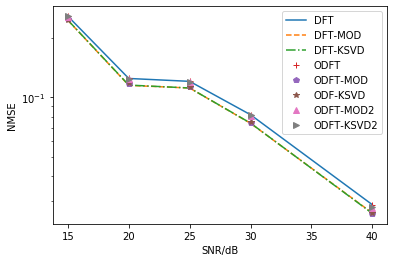

In [404]:
x=[15,20,25,30,40]
y1=[0.25616050694657394,0.12449231509567854,0.1203959398813388,0.08174512578644996,0.028809515648329665]
y2=[0.24431010200437914,0.11490443109064187,0.11144941951274051,0.07401263882320433,0.026158306329989056]
y3=[0.24472206375133124,0.11528907326257115,0.11147595636376778,0.07418334321179461,0.0260385892987672]
y4=[0.25616050694657366,0.12449231509567818,0.12039593988133847,0.08174512578644962,0.02880951564832925]
y5=[0.24850763690268848,0.1168353170453271,0.11329546292827919,0.0746149842486353,0.025877403408340452]
y6=[0.24620049023820076,0.11744326046864842,0.11313000624772002,0.07522795624593863,0.02619340909713165]
y7=[0.25494933892590327,0.12319113170801532,0.11919749756488615,0.08050388062652511,0.027622880390591506]
y8=[0.25555938564316943,0.12380462665835111,0.11983411876807461,0.08111370311440601,0.027987217462822456]
plt.plot(x, y1, '-',label = "DFT")
plt.plot(x, y2, '--',label = "DFT-MOD")
plt.plot(x, y3,'-.', label = "DFT-KSVD")
plt.plot(x, y4,'+', label = "ODFT")
plt.plot(x, y5,'p', label = "ODFT-MOD")
plt.plot(x, y6,'*', label = "ODF-KSVD")
plt.plot(x, y7,'^', label = "ODFT-MOD2")
plt.plot(x, y8,'>', label = "ODFT-KSVD2")
plt.yscale('log')
plt.xlabel('SNR/dB')
# Set the y axis label of the current axis.
plt.ylabel('NMSE')
# Set a title of the current axes.
#plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('ompnmse.pdf')
# Display a figure.
plt.show()

## sparsity

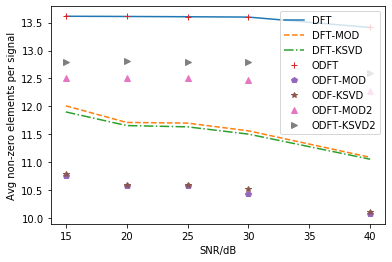

In [405]:
x=[15,20,25,30,40]
y1=[13.613,13.609,13.604,13.598,13.412]
y2=[12.011,11.714,11.702,11.564,11.090]
y3=[11.902,11.658,11.635,11.505,11.056]
y4=[13.613,13.609,13.604,13.598,13.412]
y5=[10.749,10.571,10.583,10.441,10.078]
y6=[10.794,10.598,10.597,10.518,10.112]
y7=[12.503,12.513,12.509,12.480,12.279]
y8=[12.800,12.811,12.793,12.787,12.603]
plt.plot(x, y1, '-',label = "DFT")
plt.plot(x, y2, '--',label = "DFT-MOD")
plt.plot(x, y3,'-.', label = "DFT-KSVD")
plt.plot(x, y4,'+', label = "ODFT")
plt.plot(x, y5,'p', label = "ODFT-MOD")
plt.plot(x, y6,'*', label = "ODF-KSVD")
plt.plot(x, y7,'^', label = "ODFT-MOD2")
plt.plot(x, y8,'>', label = "ODFT-KSVD2")
plt.xlabel('SNR/dB')
# Set the y axis label of the current axis.
plt.ylabel('Avg non-zero elements per signal')
# Set a title of the current axes.
#plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('ompspar.pdf')
# Display a figure.
plt.show()

# time complexity

In [ ]:
table

# stomp 

In [414]:
testst(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,5, 0.0001, 40)

([1.5790290832519531,
  2.5138309001922607,
  2.0037009716033936,
  2.0037009716033936,
  2.0037009716033936,
  2.0037009716033936,
  2.0037009716033936,
  2.0037009716033936],
 [0.00029638574600671466,
  0.0002963857460067147,
  0.0002963857460064562,
  0.0002963857460067147,
  0.00029638574600670354,
  0.0002963857460066473,
  0.00029638574600671205,
  0.0002963857460067132],
 [32000, 64000, 32000, 64000, 64000, 64000, 64000, 63999])

In [354]:
T,NM,SPAR=testst(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,10, 0.0001, 15)

In [355]:
NM

[0.6052439037906173,
 0.6052439037902232,
 0.6052439037907236,
 0.6052439037906171,
 0.6052439037906127,
 0.6052439037906127,
 0.6052439037906162,
 0.6052439037906175]

In [376]:
T2,NM2,SPAR2=testst(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,10, 0.0001, 20)

In [377]:
NM2

[0.44032197766132264,
 0.4403219776609493,
 0.44032197766139086,
 0.4403219776613224,
 0.44032197766131786,
 0.44032197766132203,
 0.44032197766132164,
 0.44032197766132286]

In [372]:
T3,NM3,SPAR3=testst(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,10, 0.0001, 25)

In [373]:
NM3

[0.08549432180664851,
 0.08549432180658709,
 0.08549432180665875,
 0.08549432180664848,
 0.08549432180664776,
 0.08549432180664643,
 0.08549432180664848,
 0.08549432180664854]

In [364]:
T4,NM4,SPAR4=testst(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,10, 0.0001, 30)

In [366]:
NM4

[0.02310917530031598,
 0.02310917530030979,
 0.02310917530032161,
 0.023109175300315962,
 0.023109175300315987,
 0.02310917530031603,
 0.02310917530031587,
 0.023109175300315987]

In [365]:
T5,NM5,SPAR5=testst(Dget,Dget2,Dget3,Dget4,Dget5,Dget6,Dget7,Dget8,10, 0.0001, 40)

In [367]:
NM5

[0.0007731545474299548,
 0.00077315454742303,
 0.0007731545474278456,
 0.0007731545474299553,
 0.0007731545474299367,
 0.0007731545474299705,
 0.0007731545474299495,
 0.0007731545474299557]

In [424]:
(statistics.mean(T5)+statistics.mean(T4)+statistics.mean(T3)+statistics.mean(T2)+statistics.mean(T))/5

3.93946088552475

## nmse

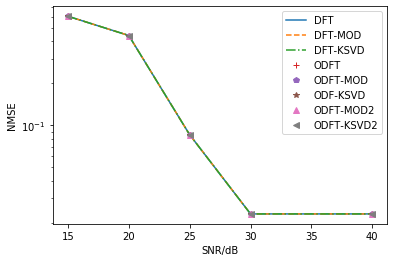

In [411]:
x=[15,20,25,30,40]
y1=[NM[0],NM2[0],NM3[0],NM4[0],NM4[0]]
y2=[NM[1],NM2[1],NM3[1],NM4[1],NM4[1]]
y3=[NM[2],NM2[2],NM3[2],NM4[2],NM4[2]]
y4=[NM[3],NM2[3],NM3[3],NM4[3],NM4[3]]
y5=[NM[4],NM2[4],NM3[4],NM4[4],NM4[4]]
y6=[NM[5],NM2[5],NM3[5],NM4[5],NM4[5]]
y7=[NM[6],NM2[6],NM3[6],NM4[6],NM4[6]]
y8=[NM[7],NM2[7],NM3[7],NM4[7],NM4[7]]

plt.plot(x, y1, '-',label = "DFT")
plt.plot(x, y2, '--',label = "DFT-MOD")
plt.plot(x, y3,'-.', label = "DFT-KSVD")
plt.plot(x, y4,'+', label = "ODFT")
plt.plot(x, y5,'p', label = "ODFT-MOD")
plt.plot(x, y6,'*', label = "ODF-KSVD")
plt.plot(x, y7,'^', label = "ODFT-MOD2")
plt.plot(x, y8,'<', label = "ODFT-KSVD2")
plt.yscale('log')
plt.xlabel('SNR/dB')
# Set the y axis label of the current axis.
plt.ylabel('NMSE')
# Set a title of the current axes.
#plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('stompnmse.pdf')
# Display a figure.
plt.show()

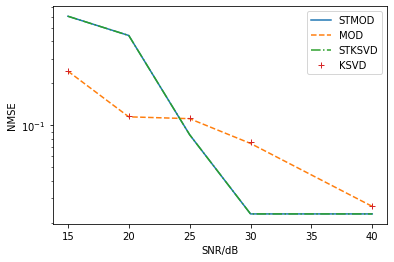

In [410]:
x=[15,20,25,30,40]
y1=[NM[1],NM2[1],NM3[1],NM4[1],NM4[1]]
y2=[0.24431010200437914,0.11490443109064187,0.11144941951274051,0.07401263882320433,0.026158306329989056]
y3=[NM[5],NM2[5],NM3[5],NM4[5],NM4[5]]
y4=[0.24620049023820076,0.11744326046864842,0.11313000624772002,0.07522795624593863,0.02619340909713165]

plt.plot(x, y1, '-',label = "STMOD")
plt.plot(x, y2, '--',label = "MOD")
plt.plot(x, y3,'-.', label = "STKSVD")
plt.plot(x, y4,'+', label = "KSVD")

plt.yscale('log')
plt.xlabel('SNR/dB')
# Set the y axis label of the current axis.
plt.ylabel('NMSE')
# Set a title of the current axes.
#plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('stompnmse2.pdf')
# Display a figure.
plt.show()


## sparsity

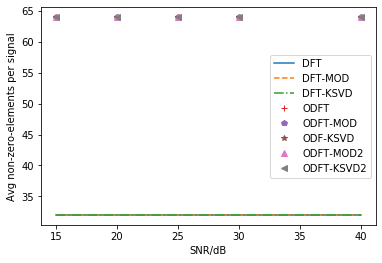

In [412]:
x=[15,20,25,30,40]
y1=[SPAR[0],SPAR2[0],SPAR3[0],SPAR4[0],SPAR4[0]]
y2=[SPAR[1],SPAR2[1],SPAR3[1],SPAR4[1],SPAR4[1]]
y3=[SPAR[2],SPAR2[2],SPAR3[2],SPAR4[2],SPAR4[2]]
y4=[SPAR[3],SPAR2[3],SPAR3[3],SPAR4[3],SPAR4[3]]
y5=[SPAR[4],SPAR2[4],SPAR3[4],SPAR4[4],SPAR4[4]]
y6=[SPAR[5],SPAR2[5],SPAR3[5],SPAR4[5],SPAR4[5]]
y7=[SPAR[6],SPAR2[6],SPAR3[6],SPAR4[6],SPAR4[6]]
y8=[SPAR[7],SPAR2[7],SPAR3[7],SPAR4[7],SPAR4[7]]

y1 = [number /1000 for number in y1]
y2 = [number /1000 for number in y2]
y3 = [number /1000 for number in y3]
y4 = [number /1000 for number in y4]
y5 = [number /1000 for number in y5]
y6 = [number /1000 for number in y6]
y7 = [number /1000 for number in y7]
y8 = [number /1000 for number in y8]

plt.plot(x, y1, '-',label = "DFT")
plt.plot(x, y2, '--',label = "DFT-MOD")
plt.plot(x, y3,'-.', label = "DFT-KSVD")
plt.plot(x, y4,'+', label = "ODFT")
plt.plot(x, y5,'p', label = "ODFT-MOD")
plt.plot(x, y6,'*', label = "ODF-KSVD")
plt.plot(x, y7,'^', label = "ODFT-MOD2")
plt.plot(x, y8,'<', label = "ODFT-KSVD2")
#plt.yscale('log')
plt.xlabel('SNR/dB')
# Set the y axis label of the current axis.
plt.ylabel('Avg non-zero-elements per signal')
# Set a title of the current axes.
#plt.title('Error function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('stompsoar.pdf')
# Display a figure.
plt.show()

In [381]:
T

[3.2006680965423584,
 4.118943929672241,
 3.9759507179260254,
 3.9759507179260254,
 3.9759507179260254,
 3.9759507179260254,
 3.9759507179260254,
 3.9759507179260254]

In [383]:
Dget=D.copy()
Dget2=D_2.copy()

In [430]:
testgd(Dget,Dget2,100,2,10,15)

11.024527072906494
16.725343942642212
10000
10000
The nmse of the first D is 3.485236391515973
The nmse of the second D is 3.686502373453187


(3.485236391515973, 3.686502373453187)

In [431]:
testgd(Dget,Dget2,100,2,10,20)

11.485075235366821
17.428125858306885
10000
10000
The nmse of the first D is 0.08893105907825793
The nmse of the second D is 0.24326897868821873


(0.08893105907825793, 0.24326897868821873)

In [432]:
testgd(Dget,Dget2,100,2,10,25)

11.781599998474121
17.414035081863403
10000
10000
The nmse of the first D is 0.43590684783977407
The nmse of the second D is 0.6362283958003048


(0.43590684783977407, 0.6362283958003048)

In [433]:
testgd(Dget,Dget2,100,2,10,30)

10.90016794204712
16.32855200767517
10000
10000
The nmse of the first D is 0.09130377412750965
The nmse of the second D is 0.24510107742510856


(0.09130377412750965, 0.24510107742510856)

In [394]:
testgd(Dget,Dget2,100,2,10,40)

10.014587163925171
15.31821584701538
10000
10000
The nmse of the first D is 0.06641745473629694
The nmse of the second D is 0.23094044938376448


(0.06641745473629694, 0.23094044938376448)

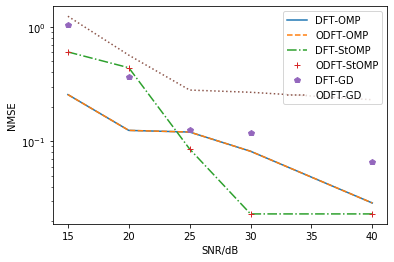

In [434]:
x=[15,20,25,30,40]
y1=[1.0417427132473547,0.3675811044331921,0.12641558728824098,0.11809050844307394,0.06641745473629694]
y2=[1.2430086951845682,0.5674877274258572,0.2806809682382783,0.2684066155146487,0.23094044938376448]
y3=[0.25616050694657394,0.12449231509567854,0.1203959398813388,0.08174512578644996,0.028809515648329665]
y4=[0.25616050694657366,0.12449231509567818,0.12039593988133847,0.08174512578644962,0.02880951564832925]
y5=[NM[0],NM2[0],NM3[0],NM4[0],NM4[0]]
y6=[NM[3],NM2[3],NM3[3],NM4[3],NM4[3]]

plt.plot(x, y3, '-',label = "DFT-OMP")
plt.plot(x, y4,'--', label = "ODFT-OMP")
plt.plot(x, y5,'-.', label = "DFT-StOMP")
plt.plot(x, y6,'+', label = "ODFT-StOMP")
plt.plot(x, y1,'p', label = "DFT-GD")
plt.plot(x, y2,':', label = "ODFT-GD")

plt.yscale('log')
plt.xlabel('SNR/dB')
# Set the y axis label of the current axis.
plt.ylabel('NMSE')
# Set a title of the current axes.
#plt.title('Error  function in dictionary learning process')
# show a legend on the plot
plt.legend()
plt.savefig('gdnmse.pdf')
# Display a figure.
plt.show()

In [198]:
testgd(Dget,Dget2,100,2,15)

1500
1500
The nmse of the first D is 0.024319210314572483
The nmse of the second D is 2.9947994228106526e+83


(0.024319210314572483, 2.9947994228106526e+83)

In [210]:
testst(Dget,Dget2,10,0.002,100)

3195
3200
The nmse of the first D is 1.241140803017878e-07
The nmse of the second D is 1.5973150019584896e-09


(1.241140803017878e-07, 1.5973150019584896e-09)